In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import pandas as pd

# import keras
# from keras import layers
# import keras.backend
# from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
# import keras.models
# import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

2.0.0


## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [2]:
list_ds = tf.data.Dataset.list_files('data/jetImages*.npz')
l_jetImages = []
l_labels = []
n = 5 #take number of files
n_images = 0 #number of images in one file
for f1 in list_ds.take(n):
    print(f1.numpy())
    with np.load(f1.numpy()) as data:
        jetImages  = np.array(data['jetImages'])
        n_images += len(jetImages)
        l_jetImages.append(jetImages)
        labels  = data['labels']
        l_labels.append(labels)
        print(labels.shape)
        print(jetImages.shape)
        
l_jetImages = np.array(l_jetImages).reshape(n_images,32,32,1)
l_labels = np.array(l_labels).reshape(n_images,1)

b'data/jetImages_signal_test.npz'
(10000, 1)
(10000, 32, 32)
b'data/jetImages_signal.npz'
(10000, 1)
(10000, 32, 32)
b'data/jetImages_bkg.npz'
(10000, 1)
(10000, 32, 32)
b'data/jetImages_bkg_test.npz'
(10000, 1)
(10000, 32, 32)


In [3]:
# import list of files

filelist = tf.data.Dataset.list_files(str('data/jetImages*.npz'))
# initialize new array and concatenate / append array to initialized array [DOES NOT WORK] trying zip


# for f1 in filelist_sig.take(1):
#     with np.load(f1.numpy()) as data:
#         jetImages = data['jetImages']
#         labels = data['labels']
        
dataset = tf.data.Dataset.from_tensor_slices((l_jetImages, l_labels))
batched_dataset = dataset.batch(4)


#for batch in batched_dataset.take(1):
#    print([arr.numpy() for arr in batch])


In [4]:
grid = 32
# training data : 10,000 signal samples and 10,000 bkg samples
traindata_sig = np.load('data/jetImages_signal.npz')
traindata_bkg = np.load('data/jetImages_bkg.npz')
trainimages = np.concatenate((traindata_sig['jetImages'], traindata_bkg['jetImages']),axis=0)
trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
# testing data : 10,000 signal samples and 10,000 bkg samples
testdata_sig = np.load('data/jetImages_signal_test.npz')
testdata_bkg = np.load('data/jetImages_bkg_test.npz')
testimages = np.concatenate((testdata_sig['jetImages'], testdata_bkg['jetImages']),axis=0)
testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)

n_test = len(testlabels)
n_train = len(trainlabels)
trainimages = trainimages.reshape(n_train, grid, grid, 1)
testimages = testimages.reshape(n_test, grid, grid, 1)
print(trainimages.shape)
print(trainlabels.shape)

(20000, 32, 32, 1)
(20000, 1)


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((l_jetImages, l_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((testimages, testlabels))

batched_test_dataset = test_dataset.batch(4)

#for batch in batched_dataset.take(4):
#  print([arr.numpy() for arr in batch])


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

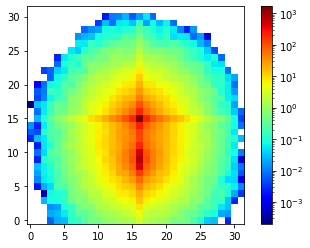

In [6]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if testlabels[i] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

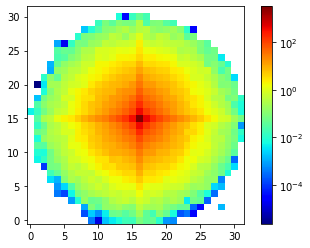

In [7]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [8]:
def build_model():
    model = keras.Sequential([
        Conv2D(32, (11, 11), activation='relu',
               input_shape=(grid, grid, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Flatten(),
        #custom input layer
        Dense(64, activation=tf.nn.relu),
        Dense(64, activation=tf.nn.relu),
#         Dropout(0.2),
        Dense(1, activation=tf.nn.sigmoid)])

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [9]:
circleCNN = build_model()

Test model's prediction $before$ training:

In [10]:
example_batch = trainimages[:10]
example_labels = trainlabels[:10]
example_result = circleCNN.predict(example_batch)
results = circleCNN.evaluate(example_batch, example_labels)
print(example_result)
print(results)

10/1 [============================================================================================================================================================================================================================================================================================================] - 0s 18ms/sample - loss: 0.6915 - mean_squared_error: 0.2492 - binary_crossentropy: 0.6915 - accuracy: 1.0000
[[0.50051457]
 [0.50101066]
 [0.5011073 ]
 [0.5006961 ]
 [0.50095487]
 [0.5009645 ]
 [0.50070333]
 [0.50070286]
 [0.5007801 ]
 [0.5009128 ]]
[0.6914793252944946, 0.24916601, 0.6914793, 1.0]


Now train! (warning: if building CNN, computer tends to get loud)

In [11]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
    
checkpoint_path = "model/CNN_sparce_cat.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    

# EPOCHS = 10
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = circleCNN.fit(
#   trainimages, trainlabels,
#   epochs=EPOCHS, validation_split = 0.2, verbose = 0,
#   callbacks=[early_stop, model_checkpoint])



In [18]:
dataset_shuffled = dataset.shuffle(buffer_size=1024).batch(16)

In [19]:
# WITH BATCHING AND SHUFFLING



EPOCHS = 10
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = circleCNN.fit(
  dataset_shuffled,
  epochs=EPOCHS)

Epoch 1/10
2500/2500 [==============================] - 49s 19ms/step - loss: 0.0499 - mean_squared_error: 0.0138 - binary_crossentropy: 0.0499 - accuracy: 0.9819
Epoch 2/10
2500/2500 [==============================] - 44s 17ms/step - loss: 0.0813 - mean_squared_error: 0.0202 - binary_crossentropy: 0.0812 - accuracy: 0.9739
Epoch 3/10
2500/2500 [==============================] - 44s 17ms/step - loss: 0.1094 - mean_squared_error: 0.0265 - binary_crossentropy: 0.1093 - accuracy: 0.9664
Epoch 4/10
2500/2500 [==============================] - 44s 17ms/step - loss: 0.1064 - mean_squared_error: 0.0251 - binary_crossentropy: 0.1063 - accuracy: 0.9693
Epoch 5/10
2500/2500 [==============================] - 44s 18ms/step - loss: 0.1694 - mean_squared_error: 0.0435 - binary_crossentropy: 0.1694 - accuracy: 0.9442
Epoch 6/10
2500/2500 [==============================] - 44s 18ms/step - loss: 0.1638 - mean_squared_error: 0.0426 - binary_crossentropy: 0.1637 - accuracy: 0.9464
Epoch 7/10
2500/2500 [

Now make a plot that shows the pregression of accuracy through each training epoch.

KeyError: 'val_mean_squared_error'

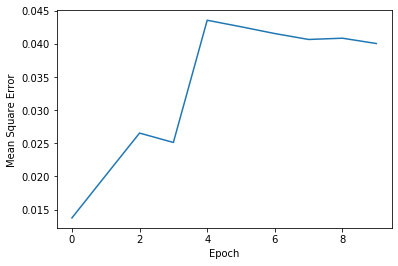

In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()

plot_history(history)

Load best weights.

In [21]:
!ls training
best_model = keras.models.load_model('model/CNN_sparce_cat.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels)
print(results)

ls: cannot access training: No such file or directory
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        3904      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
fl

[0.007287228165542183, 0.0020072758, 0.007287226, 0.99735]


Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

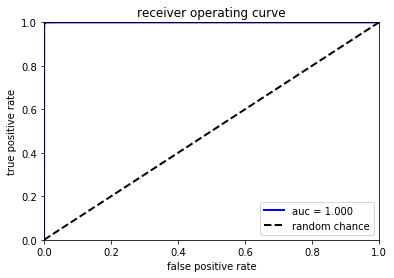

In [22]:
# Plot ROC
predict = best_model.predict(testimages)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

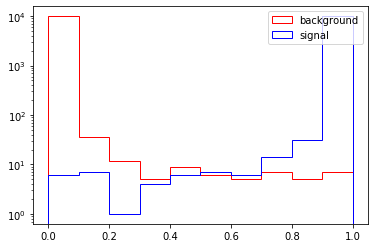

In [23]:
hist, bin_edges = np.histogram(predict[:int(len(predict)/2)])
hist_, bin_edges_ = np.histogram(predict[:-int(len((predict)-1)/2)])
plt.hist([predict[:int(len(predict)/2)].flatten(), predict[int(len(predict)/2)-1:-1].flatten()] ,
         color = ['blue', 'red'], histtype = 'step', label = ['signal', 'background'])
plt.legend()
plt.yscale('log')
plt.show()

$$ \textbf{LRP} $$

In [ ]:
# import innvestigate
# import innvestigate.utils as iutils

In [ ]:
# # Creating an analyzer
# lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
# #discoverered that innvestigate fails to run on a loaded model --> trying to find fix

# # Applying the analyzer
# display = trainimages[1].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
# analysis = lrp_analyzer.analyze(display)

# # Displaying one result
# plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar()
# plt.show()

In [ ]:
# #fix - change to predicted labels
# #plot output signal and background
# sig_analysis_true = np.zeros_like(analysis)
# bkg_analysis_true = np.zeros_like(analysis)
# sig_analysis_pred = np.zeros_like(analysis)
# bkg_analysis_pred = np.zeros_like(analysis)
# # sig_mask = trainlabels == 1
# # bkg_mask = trainlabels == 0
# # pred_sig_mask = predict >= 0.50
# # pred_bkg_mask = predict < 0.50

# toc = time.time()

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] == 1:
#         sig_analysis_true += analysis  
#     else:
#         bkg_analysis_true += analysis

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] >= 0.50:
#         sig_analysis_pred += analysis  
#     else:
#         bkg_analysis_pred += analysis

# tic = time.time()

# print('/n time = /n', tic-toc)


In [ ]:
# Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# ax.add_subplot(121)
# im = plt.imshow(sig_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)
# ax.add_subplot(122)
# im_ = plt.imshow(sig_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)

In [ ]:
# # Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# plt.subplot(121)
# im_ = plt.imshow(bkg_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)
# plt.subplot(122)
# im = plt.imshow(bkg_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)